In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely as shy
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint
import fiona
from scipy.spatial import cKDTree
import numpy as np

pd.options.display.max_rows = 4
%matplotlib inline
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share" #window

In [2]:
cd

C:\Users\jerem


In [3]:
# Open signal intersection shapefile
fp = r"Box Sync\Policy Evaluation\input_data\DOT_traffic_signals_Oct_2018\signal_controllers.shp"
df1 = gpd.read_file(fp)
df1.head(3)

,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025)
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988)
2,AVENUE OF THE AMERICAS,LISPENARD STREET,WEST BROADWAY,None,POINT (982805.6183999926 201790.0942000002)


In [4]:
df1.crs

{'proj': 'lcc',
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [5]:
# Create ID variable
df1['intersection_ID'] = df1.index
df1.head(3)

,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry,intersection_ID
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025),0
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988),1
2,AVENUE OF THE AMERICAS,LISPENARD STREET,WEST BROADWAY,None,POINT (982805.6183999926 201790.0942000002),2


In [6]:
# Open LPIs shapefile
fp = r"Box Sync\Policy Evaluation\input_data\VZV_Leading Pedestrian Interval Signals\geo_export_0c63b43f-83c0-4834-aa91-2c564c1bff2c.shp"
df2 = gpd.read_file(fp)
df2.head(3)

,cross_stre,date_insta,time_insta,lat,long,main_stree,geometry
0,Dreiser loop East,2018-08-01,00:00:00.000,40.878465,-73.828273,Co-op City Blvd,POINT (-73.82827338235253 40.87846542795222)
1,West 119 St,2018-08-08,00:00:00.000,40.803958,-73.948271,Lenox Avenue,POINT (-73.94827133431397 40.80395846158952)
2,West 120 St,2018-08-08,00:00:00.000,40.804587,-73.947812,Lenox Avenue,POINT (-73.94781210658503 40.80458679730486)


In [7]:
df2.crs

{'init': 'epsg:4326'}

In [8]:
# Reproeject LPIS shapefile to EPSG 2263: NAD83 / New York Long Island (ftUS)
df2 = df2.to_crs({'init': 'epsg:2263'})

In [9]:
# Check that 
df2.crs

{'init': 'epsg:2263'}

In [10]:
# Create ID variable
df2['LPIS_ID'] = df2.index
df2.head(3)

,cross_stre,date_insta,time_insta,lat,long,main_stree,geometry,LPIS_ID
0,Dreiser loop East,2018-08-01,00:00:00.000,40.878465,-73.828273,Co-op City Blvd,POINT (1031739.000154228 259373.000004255),0
1,West 119 St,2018-08-08,00:00:00.000,40.803958,-73.948271,Lenox Avenue,POINT (998570.9998893011 232184.9999184268),1
2,West 120 St,2018-08-08,00:00:00.000,40.804587,-73.947812,Lenox Avenue,POINT (998697.9999633889 232414.0001165908),2


In [11]:
# ckdnearest function
# from "https://gist.github.com/jhconning/63a34a51acff83d116adc52308faf240"
def ckdnearest(gdA, gdB, bcol):
    """
    This function takes geodataframes: `gdA` and `gdB` and 
    a column name `bcol`. Both dataframes are assumed to have a `geometry` column. 
    It finds the nearest neighbor from each location in `gdA` to a 
    nearest neighbor in `gdB`.  

    It returns a two-column pandas dataframe with a 'distance' (here rounded to nearest foot)
    and the value of the `bcol` in `gdB'  (e.g. 'school_name')
    """
    
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(int),
                             'bcol' : gdB.loc[idx, bcol].values })
    return df


In [12]:
df1[['distance_to_LPIS','nearest_LPIS']] = ckdnearest(df1, df2,'LPIS_ID')
df1.head(2)

C:\Users\jerem\AppData\Local\conda\conda\envs\geo\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry,intersection_ID,distance_to_LPIS,nearest_LPIS
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025),0,276,1915.0
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988),1,592,2016.0


In [13]:
# Open Streets shapefile
fp = r"Box Sync\Policy Evaluation\input_data\nyclion_points_2263/nyclion_points_2263.shp"
df3 = gpd.read_file(fp)
df3.head(3)

,OBJECTID,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,...,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Leng,geometry
0,1,EAST 168 STREET,None,0,U,None,B,None,T,DOT,...,699,596,716,599,699,596,716,2251001000000,396.030947,POINT (1010964.446978778 241812.2614034563)
1,1,EAST 168 STREET,None,0,U,None,B,None,T,DOT,...,699,596,716,599,699,596,716,2251001000000,396.030947,POINT (1011040.463264077 241747.2881445785)
2,1,EAST 168 STREET,None,0,U,None,B,None,T,DOT,...,699,596,716,599,699,596,716,2251001000000,396.030947,POINT (1011116.479549377 241682.3148857006)


In [14]:
df3.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [15]:
df1[['distance_to_Street','nearest_Street']] = ckdnearest(df1, df3,'OBJECTID')
df1.head(2)

,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry,intersection_ID,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025),0,276,1915.0,7,91705.0
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988),1,592,2016.0,17,95035.0


In [16]:
# Open Schools shapefile
fp = r"Box Sync\Policy Evaluation\input_data\school_private_public_2263\school_private_public_2263.shp"
df4 = gpd.read_file(fp)
df4.head(3)

,uid,idagency,facname,opname,address,city,zipcode,bcode,facsubgrp,factype,capacity,util,xcoord,ycoord,geometry
0,192.0,321000145390,Our Lady Of Refuge School,Our Lady Of Refuge School,2708 Briggs Avenue,Bronx,10458,36005,Non-Public K-12 Schools,Elementary School - Non-public,NaN,267.0,1.014359e+06,254977.5176,POINT (1014358.6833 254977.5176)
1,294.0,332000226225,Yeshiva Toldos Yesuscher,Yeshiva Toldos Yesuscher,1531 63 Street,Brooklyn,11219,36047,Non-Public K-12 Schools,Elementary School - Non-public,NaN,74.0,9.857114e+05,166689.5140,POINT (985711.4182 166689.514)
2,2233.0,331400225670,Ohel Elozer,Ohel Elozer,263 Classon Ave-Ste 4b,Brooklyn,11205,36047,Non-Public K-12 Schools,High School - Non-public,NaN,161.0,9.951838e+05,191390.1394,POINT (995183.844 191390.1394)


In [17]:
df4.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [18]:
df1[['distance_to_Sch','nearest_Sch']] = ckdnearest(df1, df4,'uid')
df1.head(2)

,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry,intersection_ID,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025),0,276,1915.0,7,91705.0,529,3433.0
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988),1,592,2016.0,17,95035.0,795,38150.0


In [19]:
# Open VZV Left turn calming shapefile
fp = r"Box Sync\Policy Evaluation\input_data\left_turn_traffic_calming_shapefile\left_turn_traffic_calming.shp"
df5 = gpd.read_file(fp)
df5.head(3)

,treatment_,completion,geometry
0,Quick Kurb to X-walk,2017-12-08,POINT (-73.97604825017703 40.75144139179798)
1,"Daylighting, Box markings, (1) 6' Rubber speed...",2018-04-12,POINT (-73.82577379991478 40.75635805716421)
2,Quick Kurb to X-walk,2016-06-30,POINT (-73.97719688637932 40.7643236906894)


In [20]:
df5.crs

{'init': 'epsg:4326'}

In [21]:
df5.bounds

,minx,miny,maxx,maxy
0,-73.976048,40.751441,-73.976048,40.751441
1,-73.825774,40.756358,-73.825774,40.756358
...,...,...,...,...
230,-73.805648,40.704672,-73.805648,40.704672
231,-73.897563,40.707759,-73.897563,40.707759


In [22]:
# Reproeject VZV Left turn calming shapefile to EPSG 2263: NAD83 / New York Long Island (ftUS)
df5 = df5.to_crs({'init': 'epsg:2263'})

In [23]:
df5.crs

{'init': 'epsg:2263'}

In [24]:
# Create ID variable
df5['LTC_ID'] = df5.index
df5.head(3)

,treatment_,completion,geometry,LTC_ID
0,Quick Kurb to X-walk,2017-12-08,POINT (990886.2363875993 213047.939427546),0
1,"Daylighting, Box markings, (1) 6' Rubber speed...",2018-04-12,POINT (1032518.714146682 214886.3347008746),1
2,Quick Kurb to X-walk,2016-06-30,POINT (990566.7655698524 217741.2961825352),2


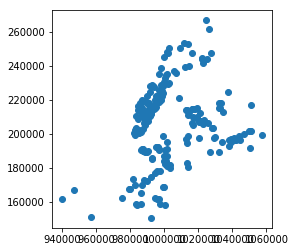

In [38]:
df5.plot()

In [25]:
df1[['distance_to_LTC','nearest_LTC']] = ckdnearest(df1, df5,'LTC_ID')
df1.head(2)

,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry,intersection_ID,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch,distance_to_LTC,nearest_LTC
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025),0,276,1915.0,7,91705.0,529,3433.0,1183,191.0
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988),1,592,2016.0,17,95035.0,795,38150.0,411,77.0


# Open VZV Street Improvement shapefile
fp = r"Box Sync\Policy Evaluation\input_data\street_improvement_projects_intersections_shapefile\street_improvement_projects_intersections.shp"
df6 = gpd.read_file(fp)
df6.tail(3)

df6.crs

# Reproeject VZV Street Improvement shapefile to EPSG 2263: NAD83 / New York Long Island (ftUS)
df6 = df6.to_crs({'init': 'epsg:2263'})

df6.crs

# Create ID variable
df6['StImpro_ID'] = df6.index
df6.head(3)

df6.plot()

df1[['distance_to_StImpro','nearest_StImpro']] = ckdnearest(df1, df6,'StImpro_ID')
df1.head(2)

In [64]:
# Open Bikeroute shapefile
fp = r"Box Sync\Policy Evaluation\input_data\bike_routes_points_2263\bike_routes_points_2263.shp"
df7 = gpd.read_file(fp)
df7.head(3)

,tf_facilit,comments,bikedir,ft_facilit,objectid_1,allclasses,date_instd,time_instd,lanecount,segment_id,boro,street,date_modda,time_modda,tostreet,fromstreet,onoffst,geometry
0,Protected Path,None,L,None,1.0,I,None,00:00:00.000,1.0,33547,1.0,9 AV,None,00:00:00.000,W 31 ST,W 16 ST,ON,POINT (984139.5802614246 211708.657997195)
1,Protected Path,None,L,None,1.0,I,None,00:00:00.000,1.0,33547,1.0,9 AV,None,00:00:00.000,W 31 ST,W 16 ST,ON,POINT (984140.0661334711 211709.5320271455)
2,Protected Path,None,L,None,1.0,I,None,00:00:00.000,1.0,33547,1.0,9 AV,None,00:00:00.000,W 31 ST,W 16 ST,ON,POINT (984140.5520055175 211710.4060570961)


In [65]:
df7.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [67]:
df1[['distance_to_bikeroute','nearest_bikeroute']] = ckdnearest(df1, df7,'segment_id')
df1.head(2)

,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry,intersection_ID,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch,distance_to_LTC,nearest_LTC,distance_to_bikeroute,nearest_bikeroute
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025),0,276,1915.0,7,91705.0,529,3433.0,1183,191.0,3,162688
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988),1,592,2016.0,17,95035.0,795,38150.0,411,77.0,230,31876


In [68]:
# Open Truckroute shapefile
fp = r"Box Sync\Policy Evaluation\input_data\truckroute_points_2263\truckroute_points_2263.shp"
df8 = gpd.read_file(fp)
df8.head(3)

,OBJECTID,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,...,Restrictio,NYC_Reg,LtdLocal,ThruExwy,LocalBrg,LocalTunl,ThruBrg,ThruTunl,Shape_Leng,geometry
0,1,TRINITY PLACE,None,0,U,None,B,None,W,DOT,...,None,"NYCDOT Traffic Rules, Section 4-13-(d)(2)",None,None,None,None,None,None,61.384654,POINT (980855.2233999987 197527.1545999364)
1,2,WATER STREET,None,0,U,None,B,None,T,DOT,...,None,"NYCDOT Traffic Rules, Section 4-13-(d)(2)",None,None,None,None,None,None,243.748254,POINT (980827.536599993 195309.7279999424)
2,2,WATER STREET,None,0,U,None,B,None,T,DOT,...,None,"NYCDOT Traffic Rules, Section 4-13-(d)(2)",None,None,None,None,None,None,243.748254,POINT (980922.8409135042 195340.0114579148)


In [69]:
df8.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [70]:
df1[['distance_to_truckroute','nearest_truckroute']] = ckdnearest(df1, df8,'OBJECTID')
df1.head(2)

,ST1_Name,ST2_Name,ST3_Name,ST4_Name,geometry,intersection_ID,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch,distance_to_LTC,nearest_LTC,distance_to_bikeroute,nearest_bikeroute,distance_to_truckroute,nearest_truckroute
0,ALLEN STREET,CANAL STREET,None,None,POINT (986336.1490000039 199793.6093000025),0,276,1915.0,7,91705.0,529,3433.0,1183,191.0,3,162688,26,892.0
1,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,None,POINT (982769.3310000002 202206.1618999988),1,592,2016.0,17,95035.0,795,38150.0,411,77.0,230,31876,17,2024.0


In [72]:
list(df1.select_dtypes(include=['object']).columns)

['ST1_Name',
 'ST2_Name',
 'ST3_Name',
 'ST4_Name',
 'geometry',
 'nearest_bikeroute']

In [74]:
df1['ST1_Name'] = df1['ST1_Name'].astype(str)
df1['ST2_Name'] = df1['ST2_Name'].astype(str)
df1['ST3_Name'] = df1['ST3_Name'].astype(str)
df1['ST4_Name'] = df1['ST4_Name'].astype(str)
df1['geometry'] = df1['geometry'].astype(str)
df1['nearest_bikeroute'] = df1['nearest_bikeroute'].astype(str)

In [75]:
fp =  r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\signal_intersection.dta"
df1.to_stata(fp)